In [1]:
!pip install tensorflow-gpu==2.2.0

In [2]:
#!pip uninstall wrapt

In [3]:
!pip install wrapt

In [4]:
"""
!pip uninstall gast
!pip uninstall h5pygast
!pip uninstall tensorboard
!pip uninstall tensorflow-estimator
"""

'\n!pip uninstall gast\n!pip uninstall h5pygast\n!pip uninstall tensorboard\n!pip uninstall tensorflow-estimator\n'

In [5]:
!pip install gast
#!pip install h5pygast
!pip install tensorboard
!pip install tensorflow-estimator

In [6]:
!pip install causalnex

In [7]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [61]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
data= pd.read_csv("/content/gdrive/MyDrive/academy/week7/feateres2.csv", na_values=['?', None])
data.head()

,diagnosis,radius_worst,perimeter_worst,area_worst,concave_points_mean,concave points_worst
0,M,25.38,184.60,2019.0,0.7119,0.2654
1,M,24.99,158.80,1956.0,0.2416,0.1860
2,M,23.57,152.50,1709.0,0.4504,0.2430
3,M,14.91,98.87,567.7,0.6869,0.2575
4,M,22.54,152.20,1575.0,0.4000,0.1625


In [29]:
import numpy as np
struct_data = data.copy()

non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['diagnosis']


In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,diagnosis,radius_worst,perimeter_worst,area_worst,concave_points_mean,concave points_worst
0,1,25.38,184.60,2019.0,0.7119,0.2654
1,1,24.99,158.80,1956.0,0.2416,0.1860
2,1,23.57,152.50,1709.0,0.4504,0.2430
3,1,14.91,98.87,567.7,0.6869,0.2575
4,1,22.54,152.20,1575.0,0.4000,0.1625


We can now apply the NOTEARS algorithm to learn the structure.

In [31]:
!git clone https://github.com/uber/causalml.git

fatal: destination path 'causalml' already exists and is not an empty directory.


In [32]:
!cd causalml

In [33]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [34]:
!pip install causalml

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression

import shap
import matplotlib.pyplot as plt

import time
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import os
import warnings
warnings.filterwarnings('ignore')

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for lightgbm to work

%reload_ext autoreload
%autoreload 2
%matplotlib inline

Visualise the learned StructureModel using the plot function.

In [36]:
plt.style.use('fivethirtyeight')

In [47]:
n_features = 5
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [38]:
w_multi = np.array(['treatment_A' if x==1 else 'control' for x in w])
e_multi = {'treatment_A': e}

In [48]:
feature_names = ['concave_points_mean', 'radius_worst','concave_points_worst','perimeter_worst','area_worst']  # specify feature names

model_tau = LGBMRegressor(importance_type='gain')  # specify model for model_tau

S Learner

In [49]:
base_algo = LGBMRegressor()
# base_algo = XGBRegressor()
# base_algo = RandomForestRegressor()
# base_algo = LinearRegression()

slearner = BaseSRegressor(base_algo, control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([0.00445078])

In [50]:
slearner_tau = slearner.fit_predict(X, w_multi, y)

Feature Importance (method = auto)

In [51]:
slearner.get_importance(X=X, 
                        tau=slearner_tau,
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': radius_worst            0.254319
 concave_points_worst    0.234373
 concave_points_mean     0.182072
 perimeter_worst         0.169837
 area_worst              0.159399
 dtype: float64}

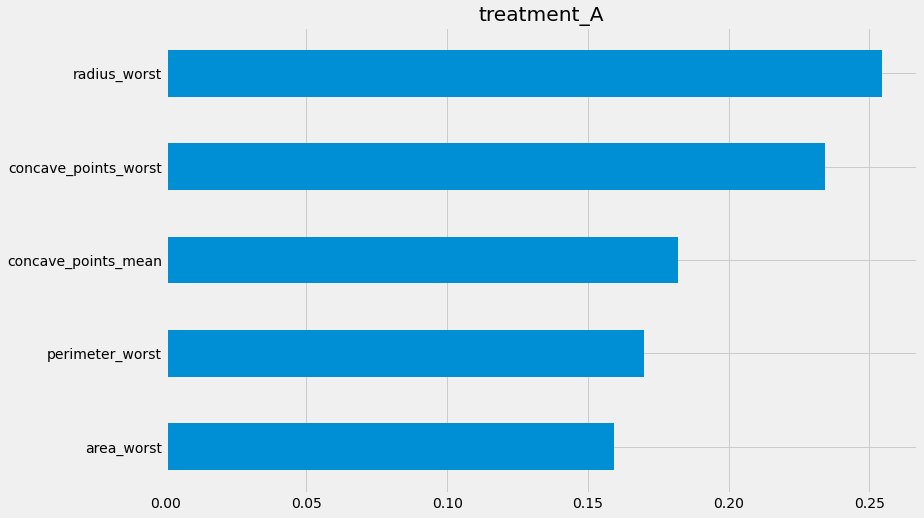

In [52]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

In [53]:
slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': concave_points_worst    0.546129
 area_worst              0.463215
 radius_worst            0.448479
 concave_points_mean     0.402111
 perimeter_worst         0.370515
 dtype: float64}

In [54]:
start_time = time.time()

slearner.get_importance(X=X, 
                        tau=slearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.7263965606689453 seconds


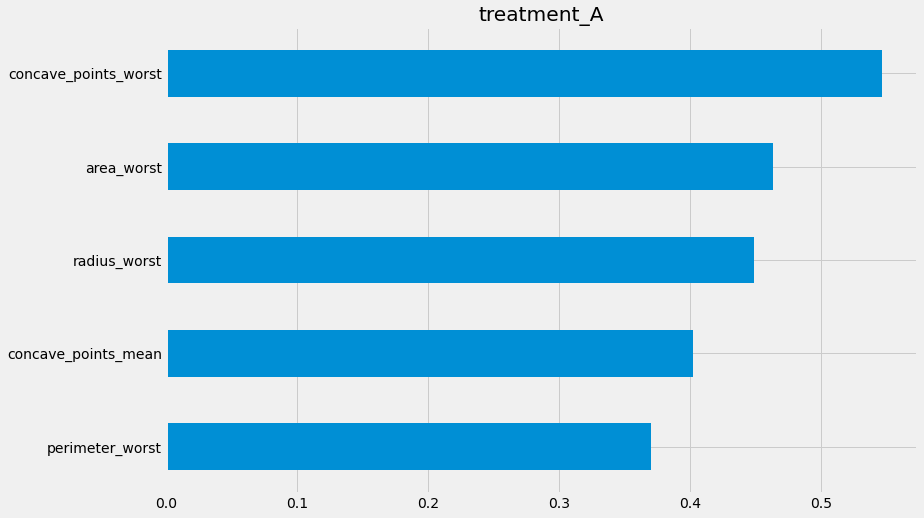

In [55]:
slearner.plot_importance(X=X, 
                         tau=slearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

Feature Importance (sklearn.inspection.permutation_importance)

In [56]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, slearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.7232589721679688 seconds


In [57]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

concave_points_worst    0.546129
area_worst              0.463215
radius_worst            0.448479
concave_points_mean     0.402111
perimeter_worst         0.370515
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

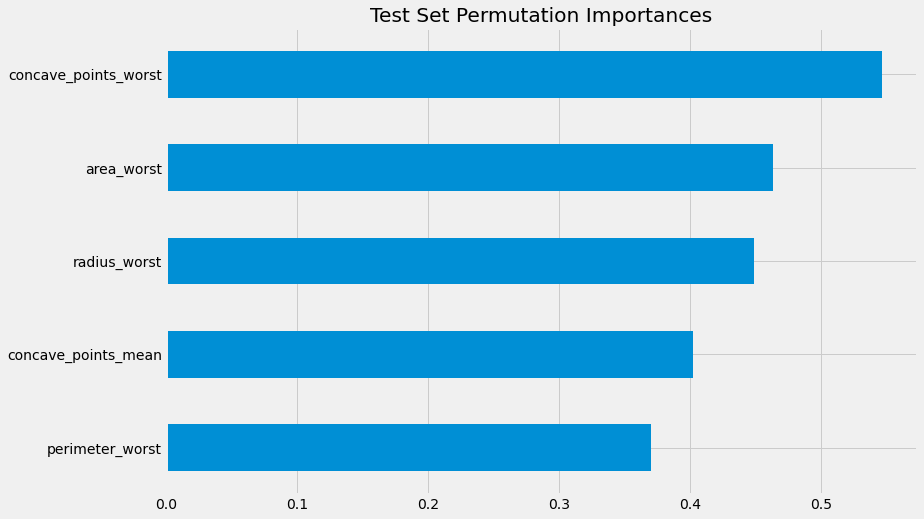

In [58]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

In [59]:
perm_imp_train = permutation_importance(
    estimator=model_tau_fit, 
    X=X_train, 
    y=y_train, 
    random_state=42).importances_mean
pd.Series(perm_imp_train, feature_names).sort_values(ascending=False)

concave_points_worst    0.621750
radius_worst            0.515329
concave_points_mean     0.470146
area_worst              0.466524
perimeter_worst         0.423868
dtype: float64

Text(0.5, 1.0, 'Training Set Permutation Importances')

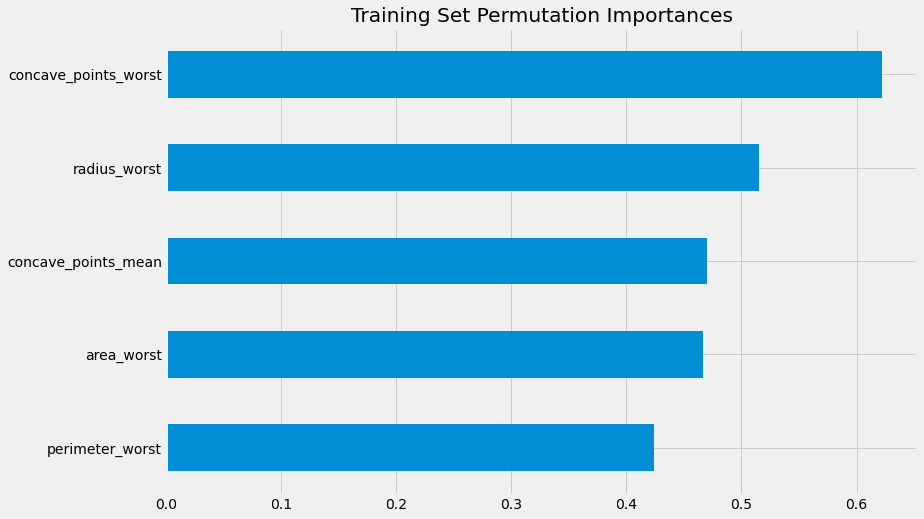

In [62]:
pd.Series(perm_imp_train, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Training Set Permutation Importances')

Shapley Values

In [63]:
shap_slearner = slearner.get_shap_values(X=X, tau=slearner_tau)
shap_slearner

{'treatment_A': array([[ 3.81536886e-04,  2.70769827e-03,  4.99066952e-03,
          5.62272930e-03,  3.21354900e-03],
        [ 5.50421860e-03, -3.99583796e-03,  5.96990728e-03,
          6.84697278e-04,  4.12474969e-03],
        [ 1.07788241e-02,  2.68039510e-03,  1.48336532e-04,
          1.97417481e-06, -2.06095564e-02],
        ...,
        [ 2.43068749e-03, -3.01759265e-03,  3.73968774e-04,
         -5.92002382e-03,  5.11096995e-04],
        [-8.60209340e-04,  5.88381696e-03,  8.09486416e-03,
          2.02709713e-03, -1.63776398e-04],
        [ 1.79696188e-03,  5.51530997e-03,  1.34125320e-02,
          7.22988392e-04,  1.04400983e-02]])}

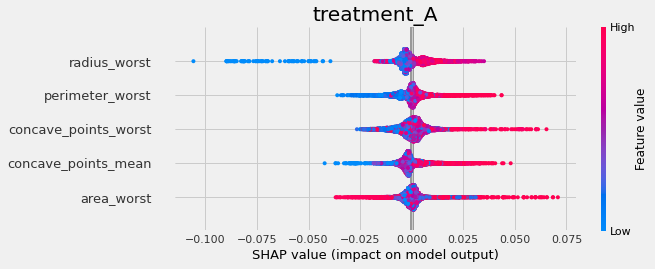

In [64]:
# Plot shap values without specifying shap_dict
slearner.plot_shap_values(X=X, tau=slearner_tau, features=feature_names)

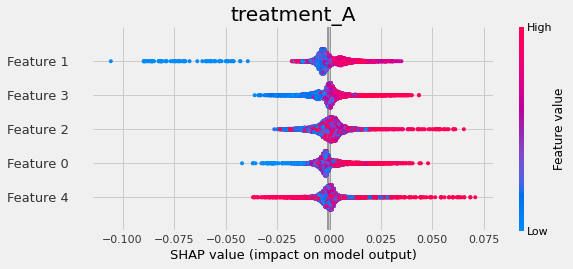

In [65]:
# Plot shap values WITH specifying shap_dict
slearner.plot_shap_values(X=X, shap_dict=shap_slearner)

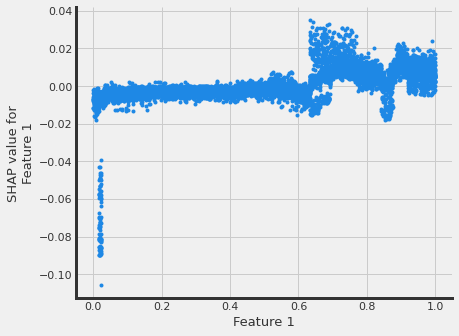

In [66]:
# interaction_idx set to None (no color coding for interaction effects)
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx=1,
                              X=X,
                              tau=slearner_tau,
                              interaction_idx=None,
                              shap_dict=shap_slearner)

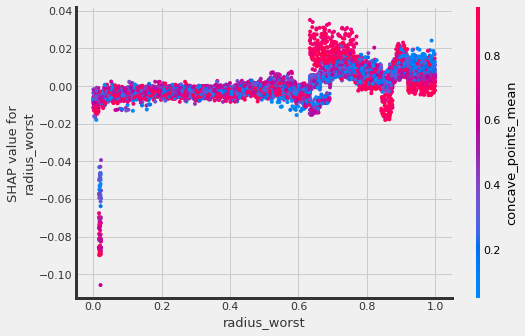

In [70]:
# interaction_idx set to 'auto' (searches for feature with greatest approximate interaction)
# specify feature names
slearner.plot_shap_dependence(treatment_group='treatment_A',
                              feature_idx='radius_worst',
                              X=X,
                              tau=slearner_tau,
                              interaction_idx='auto',
                              shap_dict=shap_slearner,
                              features=feature_names)

T Learner

In [74]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([0.00397096]), array([-0.01367831]), array([0.02162024]))

In [75]:
tlearner_tau = tlearner.fit_predict(X, w_multi, y)

Feature Importance (method = auto)

In [76]:
tlearner.get_importance(X=X, 
                        tau=tlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': concave_points_worst    0.213290
 concave_points_mean     0.213243
 radius_worst            0.212410
 perimeter_worst         0.180890
 area_worst              0.180167
 dtype: float64}

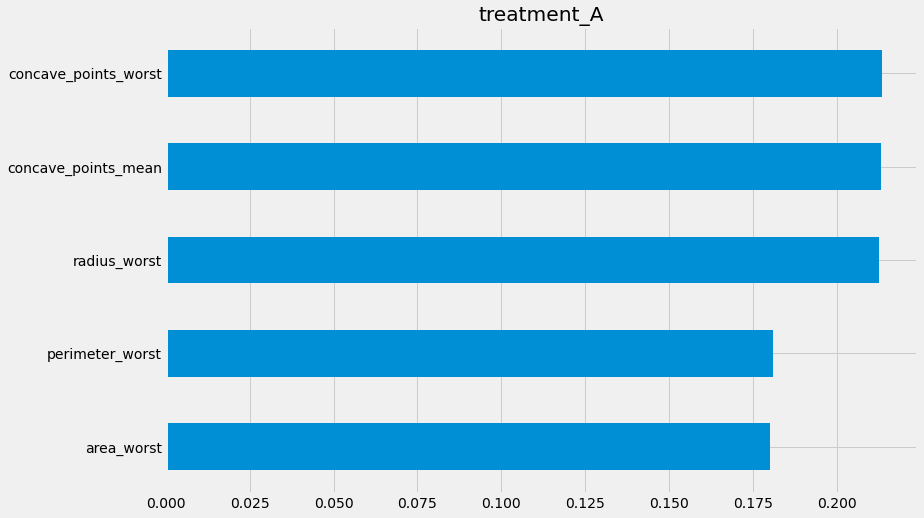

In [77]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

Feature Importance (method = permutation)

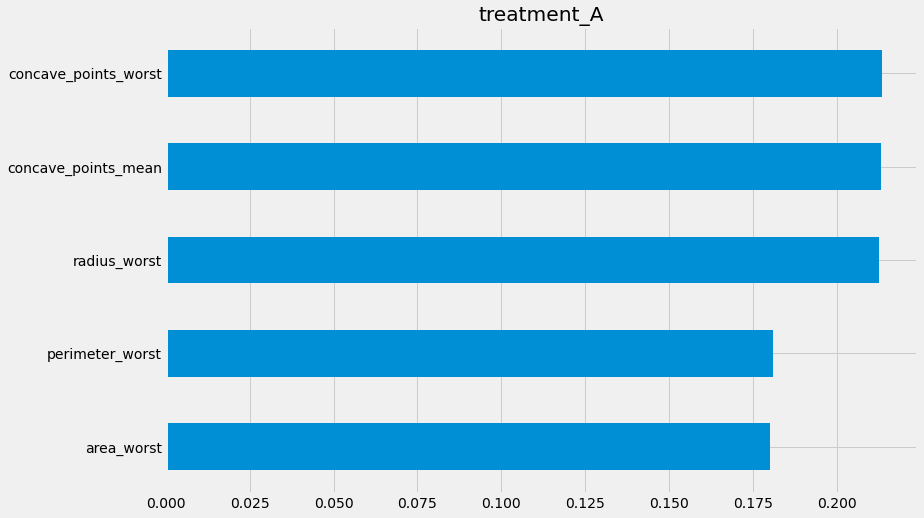

In [78]:
tlearner.plot_importance(X=X, 
                         tau=tlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

Feature Importance (sklearn.inspection.permutation_importance)

In [79]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, tlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.7584145069122314 seconds


Text(0.5, 1.0, 'Test Set Permutation Importances')

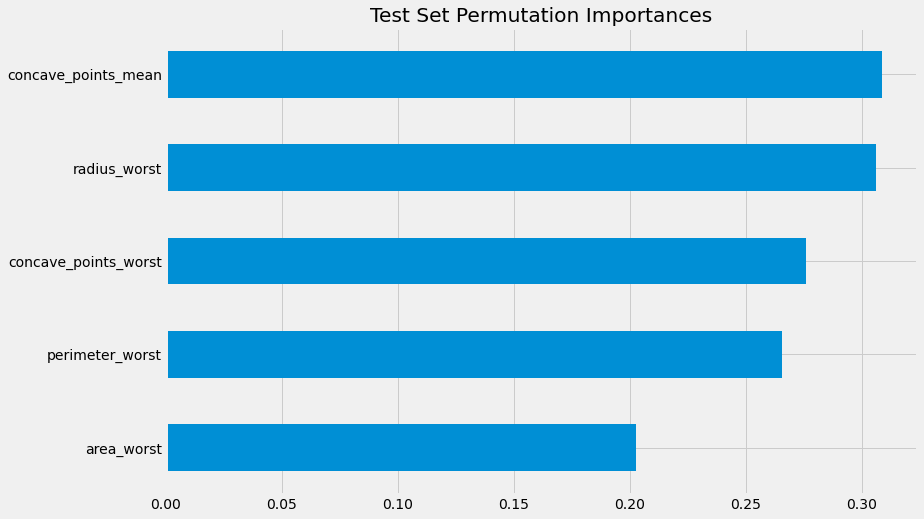

In [80]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

Shapley Values

In [82]:
shap_tlearner = tlearner.get_shap_values(X=X, tau=tlearner_tau)
shap_tlearner

{'treatment_A': array([[-2.52199656e-02, -9.63725681e-03,  3.30477566e-02,
          1.18669998e-02,  3.87751332e-02],
        [ 4.58049872e-02,  1.43439312e-02,  5.34573635e-02,
         -9.40920992e-03,  3.86308787e-03],
        [-1.61904311e-01, -1.37196602e-02, -1.05480170e-03,
          4.80746196e-02, -9.56650834e-02],
        ...,
        [ 3.59381207e-02, -2.57625916e-02, -5.06814517e-02,
          6.26327565e-02, -3.25563981e-02],
        [ 9.27167487e-03, -4.61277363e-02,  2.87735744e-02,
         -2.24987414e-02, -4.64239255e-02],
        [-1.37971990e-03, -2.94802451e-03, -4.73493783e-05,
          2.29958769e-03,  2.78843909e-02]])}

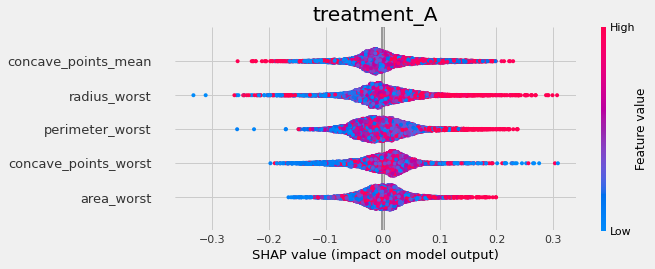

In [83]:
# Plot shap values without specifying shap_dict
tlearner.plot_shap_values(X=X, tau=tlearner_tau, features=feature_names)

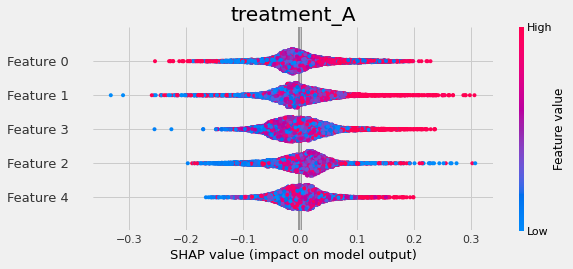

In [84]:
# Plot shap values WITH specifying shap_dict
tlearner.plot_shap_values(X=X, shap_dict=shap_tlearner)

X Learner

In [86]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, w_multi, y, p=e_multi)

(array([0.00387635]), array([-0.01339687]), array([0.02114956]))

In [87]:
xlearner_tau = xlearner.predict(X, w_multi, y, p=e_multi)

In [88]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        normalize=True, 
                        method='auto', 
                        features=feature_names)

{'treatment_A': concave_points_mean     0.246955
 radius_worst            0.200646
 area_worst              0.198140
 concave_points_worst    0.180265
 perimeter_worst         0.173994
 dtype: float64}

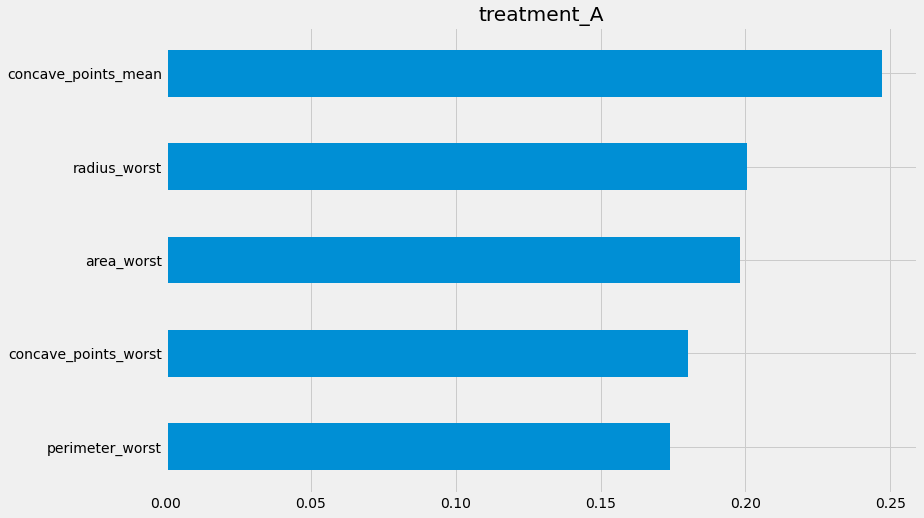

In [89]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         normalize=True, 
                         method='auto', 
                         features=feature_names)

Feature Importance (method = permutation

In [90]:
xlearner.get_importance(X=X, 
                        tau=xlearner_tau, 
                        method='permutation', 
                        features=feature_names, 
                        random_state=42)

{'treatment_A': concave_points_mean     0.416122
 radius_worst            0.341451
 perimeter_worst         0.284611
 concave_points_worst    0.283742
 area_worst              0.256599
 dtype: float64}

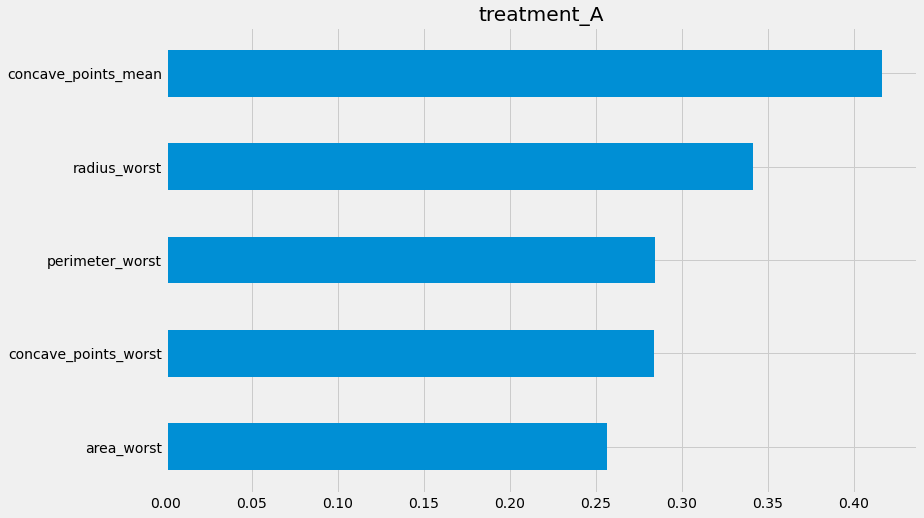

In [91]:
xlearner.plot_importance(X=X, 
                         tau=xlearner_tau, 
                         method='permutation', 
                         features=feature_names, 
                         random_state=42)

Feature Importance (sklearn.inspection.permutation_importance)

In [92]:
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, xlearner_tau, test_size=0.3, random_state=42)
model_tau_fit = model_tau.fit(X_train, y_train)

perm_imp_test = permutation_importance(
    estimator=model_tau_fit, 
    X=X_test, 
    y=y_test, 
    random_state=42).importances_mean
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

print("Elapsed time: %s seconds" % (time.time() - start_time))

Elapsed time: 0.82781982421875 seconds


In [93]:
pd.Series(perm_imp_test, feature_names).sort_values(ascending=False)

concave_points_mean     0.416122
radius_worst            0.341451
perimeter_worst         0.284611
concave_points_worst    0.283742
area_worst              0.256599
dtype: float64

Text(0.5, 1.0, 'Test Set Permutation Importances')

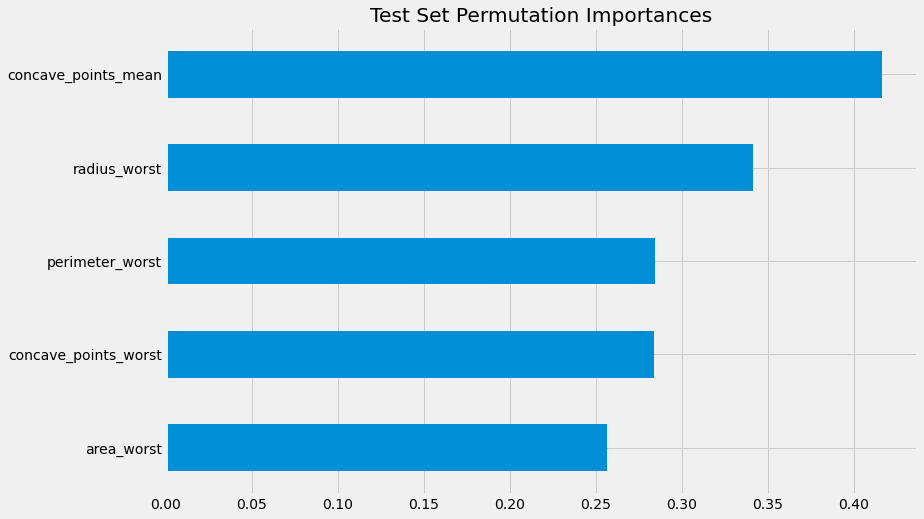

In [94]:
pd.Series(perm_imp_test, feature_names).sort_values().plot(kind='barh', figsize=(12, 8))
plt.title('Test Set Permutation Importances')

Shapley Values

In [95]:
shap_xlearner = xlearner.get_shap_values(X=X, tau=xlearner_tau)
shap_xlearner

{'treatment_A': array([[-0.02564855, -0.01604393,  0.01723933, -0.00092333,  0.02147055],
        [ 0.04563336,  0.00335406,  0.0401786 , -0.01402146,  0.00772138],
        [-0.12808892, -0.01037853, -0.00654972,  0.0470912 , -0.10637345],
        ...,
        [ 0.02730939, -0.02588903, -0.04336863,  0.05862424, -0.02834987],
        [ 0.00329106, -0.0384446 ,  0.03346975, -0.02512992, -0.02816586],
        [-0.007657  , -0.00056026, -0.01052108, -0.0279925 ,  0.02728529]])}

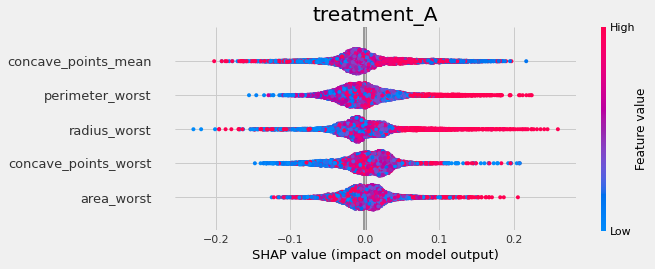

In [96]:
# shap_dict not specified
xlearner.plot_shap_values(X=X, tau=xlearner_tau, features=feature_names)

### Uplift Tree/Forest
Note that uplift trees/forests are only implemented for classification at the moment, hence the following section uses a different synthetic data generation process.

UpliftTreeClassifier

In [97]:
from causalml.dataset import make_uplift_classification

df, x_names = make_uplift_classification()

In [101]:
uplift_tree = UpliftTreeClassifier(control_name='control')

uplift_tree.fit(X=df[x_names].values,
                treatment=df['treatment_group_key'].values,
                y=df['conversion'].values)

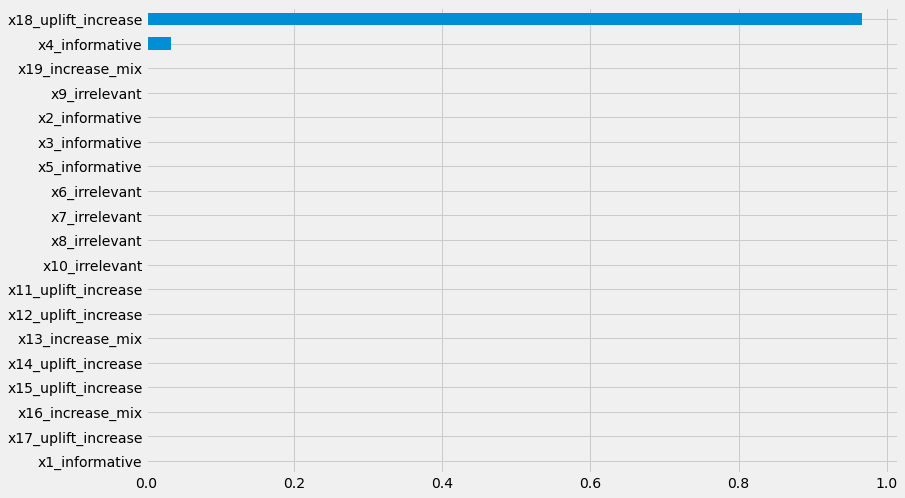

In [99]:
pd.Series(uplift_tree.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))

UpliftRandomForestClassifier

In [102]:
uplift_rf = UpliftRandomForestClassifier(control_name='control')

uplift_rf.fit(X=df[x_names].values,
              treatment=df['treatment_group_key'].values,
              y=df['conversion'].values)

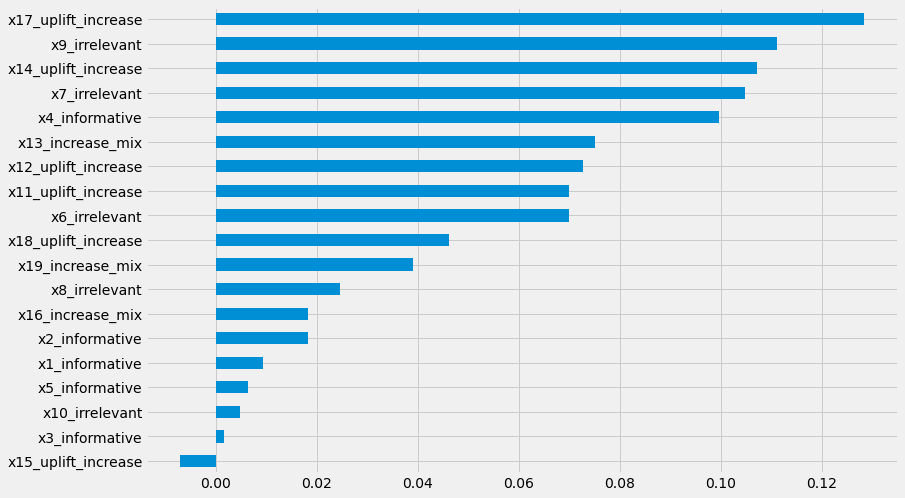

In [103]:
pd.Series(uplift_rf.feature_importances_, index=x_names).sort_values().plot(kind='barh', figsize=(12,8))